In [2]:
import torch
from PIL import Image
import torchmetrics
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import random
from tqdm import tqdm

device = 'cuda'
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

## 1. Подготовка данных

In [3]:
class CCPD2019Dataset(Dataset):
    def __init__(self, dir, transform):
        import os
        self.dir = dir
        self.file_names = os.listdir(dir)
        self.length = len(self.file_names)
        self.labels = [file_name.split('-')[1].split('.')[0] for file_name in self.file_names]
        self.transforms = transform

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        file_name = self.dir + '/' + self.file_names[index]
        label = self.labels[index]
        img = self.transforms(Image.open(file_name).convert("RGB"))
        return img, label

На данном этапе аугментация не была использована, трансформации для теста, трэйна и валидационной выборки одинаковы.

In [4]:
train_transforms = transforms.Compose([
            transforms.Resize((64, 128)),
            transforms.AugMix(severity=2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_transforms = transforms.Compose([
            transforms.Resize((64, 128)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [5]:
train = CCPD2019Dataset('CCPD2019-dl1/train', test_transforms)
test = CCPD2019Dataset('CCPD2019-dl1/test', test_transforms)
all_symbols = list(set(list(''.join(train.labels))))
symb2num = {key: val for val, key in enumerate(all_symbols)}
num2symb = {key: val for key, val in enumerate(all_symbols)}
train, val = torch.utils.data.random_split(train, [len(train) - len(train)//8, len(train)//8])
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)


In [9]:
def text2target(text_batch):
    '''
    Transforms symbols to target labels.
    '''

    targets = [[symb2num[symb] for symb in text] for text in text_batch]
    targets = torch.Tensor(targets).T
    
    return targets

In [ ]:
def compute_loss(text_batch, preds, criterion, length):
    '''
    Prepares model output for CTC-loss and computes it.
    '''
    
    lengths = torch.IntTensor([length]*len(text_batch))
    
    preds = F.log_softmax(preds, 2).permute(1, 0, 2)
    targets = [[symb2num[symb] for symb in text] for text in text_batch]
    targets = torch.IntTensor(targets).to(device)
    loss = criterion(preds, targets, lengths, lengths)

    return loss

In [ ]:
def decode_predictions(preds):
    '''
    Transforms model predictions to string.
    '''

    preds = F.softmax(preds, 2).argmax(2) 
    preds = preds.cpu().numpy() 

    texts = []
    for token in preds:
        text = [num2symb[index] for index in token]
        text = "".join(text)
        texts.append(text)

    return texts

## 2. Модель

Дальнейшее усложнение модели начало зачастую приводить к быстрому переобучению, поэтому было решено остановится на 6 конволюционных слоях и 3 слоях GRU (более современный аналог классического LSTM).

In [19]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__() # 64 * 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(5, 5)) # 60 * 124
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5)) # 56 * 120
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2) # 26 * 58
        self.norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=2) # 12 * 28
        self.norm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=2, padding=1) # 6 * 14
        self.norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=2, padding=1) # 3 * 7
        self.norm6 = nn.BatchNorm2d(256)
        self.output_size = 3
        self.gru_input_size = self.output_size * 256
        self.gru = nn.GRU(self.gru_input_size, 128, 3, 
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, len(symb2num))

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = self.conv5(out)
        out = self.norm5(out)
        out = F.leaky_relu(out)
        out = self.conv6(out)
        out = self.norm6(out)
        out = F.leaky_relu(out)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([self.fc(out[i]) for i in range(out.shape[0])])
        return out


model = CRNN().to(device)
criterion = nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

In [23]:
def train_epoch(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    
    model.to(device)
    model.train(True)
    train_loss = 0
    for X, y in tqdm(dataloader):
        X = X.to(device)
        pred = model(X)
        loss = compute_loss(y, pred, criterion, 7)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    model.train(False)

    train_loss /= len(dataloader)
    print(f'Train loss: {train_loss}')
    
def val_epoch(dataloader, model, criterion):
    model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    preds = []
    targets = []
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            targets += y
            pred = model(X)
            test_loss += compute_loss(y, pred, criterion, 7).item()
            pred = decode_predictions(pred)
            preds += pred

    test_loss /= num_batches
    accuracy = np.mean(np.array(targets) == np.array(preds))
    cer = torchmetrics.functional.char_error_rate(preds, targets)
    print(f"Validation loss: {test_loss}")
    print(f"Validation accuracy: {accuracy}")
    print(f"Validation CER: {cer}")

In [24]:
for t in range(5):
    print(f"Epoch {t+1}")
    train_epoch(train_loader, model, criterion, optimizer)
    val_epoch(val_loader, model, criterion)

Epoch 1


100%|██████████| 10937/10937 [11:54<00:00, 15.30it/s]


Train loss: 0.06016237661242485
Validation loss: 0.013976114766590473
Validation accuracy: 0.9693963275593072
Validation CER: 0.005006315186619759
Epoch 2


100%|██████████| 10937/10937 [11:51<00:00, 15.37it/s]


Train loss: 0.013245224952697754
Validation loss: 0.009703861589791397
Validation accuracy: 0.9795175421050526
Validation CER: 0.0032060989178717136
Epoch 3


100%|██████████| 10937/10937 [11:45<00:00, 15.51it/s]


Train loss: 0.00996019784361124
Validation loss: 0.014827027119764961
Validation accuracy: 0.9660359243109173
Validation CER: 0.005514947697520256
Epoch 4


100%|██████████| 10937/10937 [11:38<00:00, 15.66it/s]


Train loss: 0.008377237245440483
Validation loss: 0.007557852707396727
Validation accuracy: 0.9859583149977997
Validation CER: 0.0022002640180289745
Epoch 5


100%|██████████| 10937/10937 [11:31<00:00, 15.81it/s]


Train loss: 0.007359154988080263
Validation loss: 0.006586856607210903
Validation accuracy: 0.9870784494139296
Validation CER: 0.002074534771963954


При продолжении обучения дольше 5 эпох, начинает происходить переобучение, поэтому было решено остановится на этом.

## 3. Метрики

In [25]:
with torch.no_grad():
        preds = []
        targets = []
        for X, y in test_loader:
            X = X.to(device)
            targets += y
            pred = model(X)
            pred = decode_predictions(pred)
            preds += pred

In [28]:
print(f'Accuracy: {np.mean(np.array(targets) == np.array(preds))}')

Accuracy: 0.9555955595559555


In [30]:
print(f'CER: {torchmetrics.functional.char_error_rate(preds, targets)}')

CER: 0.008772306144237518


# Добавим аугментацию

Было опробовано 2 готовых метода аугментации из pytorch, не специфичных для какого-либо датасета: RandAugment и AugMix, второй показал себя лучше.

In [45]:
train = CCPD2019Dataset('CCPD2019-dl1/train', train_transforms)
test = CCPD2019Dataset('CCPD2019-dl1/test', test_transforms)
all_symbols = list(set(list(''.join(train.labels))))
symb2num = {key: val for val, key in enumerate(all_symbols)}
num2symb = {key: val for key, val in enumerate(all_symbols)}
train, val = torch.utils.data.random_split(train, [len(train) - len(train)//8, len(train)//8])
batch_size = 16
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
val.transforms = test_transforms

In [46]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__() # 64 * 128
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(5, 5)) # 60 * 124
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5)) # 56 * 120
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(5, 5), stride=2) # 26 * 58
        self.norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=2) # 12 * 28
        self.norm4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=2, padding=1) # 6 * 14
        self.norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=2, padding=1) # 3 * 7
        self.norm6 = nn.BatchNorm2d(256)
        self.output_size = 3
        self.gru_input_size = self.output_size * 256
        self.gru = nn.GRU(self.gru_input_size, 128, 3, 
                          batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, len(symb2num))

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = self.conv5(out)
        out = self.norm5(out)
        out = F.leaky_relu(out)
        out = self.conv6(out)
        out = self.norm6(out)
        out = F.leaky_relu(out)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([self.fc(out[i]) for i in range(out.shape[0])])
        return out


model = CRNN().to(device)
criterion = nn.CTCLoss(reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)

В этот раз будем обучать 10 эпох, переобучение с добавлением аугментации так быстро не наступает

In [47]:
for t in range(10):
    print(f"Epoch {t+1}")
    train_epoch(train_loader, model, criterion, optimizer)
    val_epoch(val_loader, model, criterion)

Epoch 1


100%|██████████| 10937/10937 [19:01<00:00,  9.58it/s]


Train loss: 0.06987452507019043
Validation loss: 0.01817554038576454
Validation accuracy: 0.9542345081409769
Validation CER: 0.007646631915122271
Epoch 2


100%|██████████| 10937/10937 [20:03<00:00,  9.09it/s]


Train loss: 0.017062509432435036
Validation loss: 0.010155645285202583
Validation accuracy: 0.9772772732727928
Validation CER: 0.003783311229199171
Epoch 3


100%|██████████| 10937/10937 [20:56<00:00,  8.71it/s]


Train loss: 0.012864122167229652
Validation loss: 0.010796413468289346
Validation accuracy: 0.9753170380445654
Validation CER: 0.0041547841392457485
Epoch 4


100%|██████████| 10937/10937 [21:31<00:00,  8.47it/s]


Train loss: 0.011466502211987972
Validation loss: 0.010206580848520743
Validation accuracy: 0.9781573788854663
Validation CER: 0.0035318525042384863
Epoch 5


100%|██████████| 10937/10937 [21:37<00:00,  8.43it/s]


Train loss: 0.010347955860197544
Validation loss: 0.01049546582542535
Validation accuracy: 0.977957354882586
Validation CER: 0.003737591439858079
Epoch 6


100%|██████████| 10937/10937 [20:26<00:00,  8.92it/s]


Train loss: 0.009672357700765133
Validation loss: 0.009199437324669133
Validation accuracy: 0.9817178061367364
Validation CER: 0.003091799560934305
Epoch 7


100%|██████████| 10937/10937 [21:26<00:00,  8.50it/s]


Train loss: 0.009195965714752674
Validation loss: 0.01287536659565178
Validation accuracy: 0.9708765051806216
Validation CER: 0.00472056632861495
Epoch 8


100%|██████████| 10937/10937 [21:11<00:00,  8.60it/s]


Train loss: 0.009038240648806095
Validation loss: 0.00857556134776894
Validation accuracy: 0.9816778013361603
Validation CER: 0.0029260653536766768
Epoch 9


100%|██████████| 10937/10937 [20:41<00:00,  8.81it/s]


Train loss: 0.00879652425646782
Validation loss: 0.007900829362647693
Validation accuracy: 0.9823578829459535
Validation CER: 0.0028632006142288446
Epoch 10


100%|██████████| 10937/10937 [19:25<00:00,  9.39it/s]


Train loss: 0.008680752478539944
Validation loss: 0.009450837412841025
Validation accuracy: 0.9775973116774013
Validation CER: 0.0035089924931526184


In [48]:
with torch.no_grad():
        preds = []
        targets = []
        for X, y in test_loader:
            X = X.to(device)
            targets += y
            pred = model(X)
            pred = decode_predictions(pred)
            preds += pred

In [49]:
print(f'Accuracy: {np.mean(np.array(targets) == np.array(preds))}')

Accuracy: 0.9551955195519551


In [50]:
print(f'CER: {torchmetrics.functional.char_error_rate(preds, targets)}')

CER: 0.00805794820189476


Долю неверно распознанных букв удалось немного снизить, возможно, при переборе параметров аугментации и более долгом обучении удалось бы добиться еще лучшего качества.

## 4. Анализ ошибок (для итогового варианта с аугментацией)

In [51]:
preds_ = np.array([list(pred) for pred in preds])
targets_ = np.array([list(target) for target in targets])

In [52]:
np.sort(np.sum(preds_ == targets_, axis=1))[:10]

array([2, 2, 3, 3, 3, 4, 4, 4, 4, 4])

Посмотрим на те случаи, когда верно распознанных букв меньше 4.

In [53]:
np.nonzero(np.sum(preds_ == targets_, axis=1) < 4)

(array([ 541, 3805, 4046, 4247, 5707]),)

Prediction: 皖AM933K, target: 皖AC928R


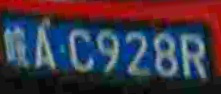

In [59]:
i = 541
print(f'Prediction: {preds[i]}, target: {targets[i]}')
Image.open("CCPD2019-dl1/test/" + test.file_names[i]).convert("RGB")

Prediction: 豫TQ77KF, target: 皖E97765


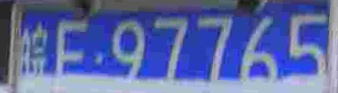

In [60]:
i = 3805
print(f'Prediction: {preds[i]}, target: {targets[i]}')
Image.open("CCPD2019-dl1/test/" + test.file_names[i]).convert("RGB")

Prediction: 皖AJ3393, target: 皖ABJ356


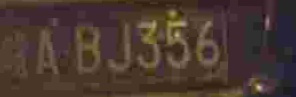

In [61]:
i = 4046
print(f'Prediction: {preds[i]}, target: {targets[i]}')
Image.open("CCPD2019-dl1/test/" + test.file_names[i]).convert("RGB")

Prediction: 皖AZN6G9, target: 皖A2W003


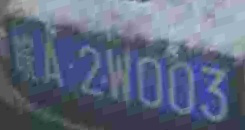

In [62]:
i = 4247
print(f'Prediction: {preds[i]}, target: {targets[i]}')
Image.open("CCPD2019-dl1/test/" + test.file_names[i]).convert("RGB")

Prediction: 皖AR8379, target: 皖AK927W


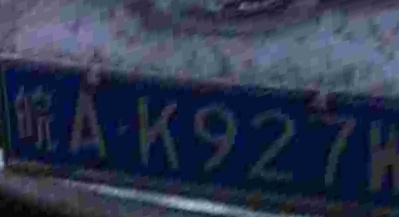

In [63]:
i = 5707
print(f'Prediction: {preds[i]}, target: {targets[i]}')
Image.open("CCPD2019-dl1/test/" + test.file_names[i]).convert("RGB")

Для картинок выше характерно то, что они или были сняты по углом или буквы частично обрезаны. С этим может помочь справится более умный подход к аугментации с перебором параметров или написания своей процедуры под данную задачу. Также, возможно, поможет усложнение архитектуры нейросети, что может позволить ей справляться с такими ситуациями и более специфично определять символы, однако для этого требуется много времени и ресурсов на обучение и эксперименты с архитектурами. 